What does an infinitely wide transformer look like? We will calculate its [Neural Tangent Kernel](https://arxiv.org/abs/1806.07572) in this notebook, according to [our paper](https://arxiv.org/abs/2006.14548), so you can find out yourself!

In [1]:
!git clone -q https://github.com/thegregyang/NTK4A
%cd NTK4A/

In [2]:
import numpy as np
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
from itertools import product
from tqdm import tqdm
sns.set()

In [3]:
from utils import VReLU, VStep, paramdot, clone_grads, getCor

<img src="https://raw.githubusercontent.com/thegregyang/NTK4A/master/images/transformer.png" width=600 />

<img src="https://raw.githubusercontent.com/thegregyang/NTK4A/master/images/transformer_setup.png" width=600 />

We will use the attention with key-query scaling $1/d_{head} = 1/n$ instead of $1/\sqrt{d_{head}}$.

<img src="https://raw.githubusercontent.com/thegregyang/NTK4A/master/images/attention.png" width=600 />

# Finite-Width Neural Network

In [4]:
from utils import getCor

def blockdiag(C):
    M, T, _, _ = C.shape
    Z = np.zeros([M, M])
    np.fill_diagonal(Z, 1)
    return Z[:, None, :, None] * C

def getkers(C, depth, vw=1, vu=1, vv=1):
    M, T, _, _ = C.shape
    C = C.reshape(M*T, M*T)
    Cxs = [C]
    Cks = []
    As = []
    Cys = []
    Czs = []
    Deltazs = []
    Cgs = []
    Chs = []
    Deltaxs = []
    
    Dxs = [vv/T**2 * np.ones_like(C)]
    Dhs = []
    Dgs = []
    Dzs = []
    Dys = []
    Dks = []
    
    for i in range(depth):
        Cks += [vu * Cxs[-1]]
        A = blockdiag(
            sp.special.softmax(Cks[-1].reshape(M, T, M, T), axis=-1)
            ).reshape(M*T, M*T)
        As += [A]
        AI = A + np.eye(A.shape[0])
        Cys += [AI @ Cks[-1] @ AI.T]
        Czs += [getCor(Cys[-1])]
        Deltazs += [np.diag(Cys[-1]) ** -0.5]
        Cgs += [vw * Czs[-1]]
        Chs += [vw * VReLU(Cgs[-1])]
        Cxs += [getCor(Chs[-1] + Czs[-1])]
        Deltaxs += [np.diag(Chs[-1] + Czs[-1])**-0.5]
        
    for i in range(depth):
        Dhs += [Deltaxs[-1-i][:, None] * Dxs[-1] * Deltaxs[-1-i][None, :]]
        Dgs += [vw * Dhs[-1] * VStep(Cgs[-1-i])]
        Dzs += [vw * Dgs[-1] + Dhs[-1]]
        Dys += [Deltazs[-1-i][:, None] * Dzs[-1] * Deltazs[-1-i][None, :]]
        AI = As[-1-i] + np.eye(As[-1].shape[0])
        Dks += [AI.T @ Dys[-1] @ AI]
        Dxs += [vu**2 * Dks[-1]]
        
    # Dgs[0] = Dg^L
    # Dgs[L-1] = Dg^1
    # Cgs[0] = Cgs^1
    # Cgs[L-1] = Cgs^L
    # Dxs[0] = Dx^L
    # Dxs[L] = Dx^0
    # Cxs[0] = Cx^0
    # Cxs[L] = Cx^L
        
    assert len(Cxs) == depth+1
    
    ntk = np.mean(Cxs[-1].reshape(M, T, M, T), axis=(1,3))
    def om(C, D):
        return np.einsum('ijkl,ijkl->ik',
                         C.reshape(M, T, M, T), 
                         D.reshape(M, T, M, T))
    
    for l in range(1, depth+1):
        # Dks[-1-l+1] = Dk^l
        ntk += om(Dks[-1-l+1], Cxs[l-1])
        ntk += om(Dgs[-1-l+1], Czs[l-1])
        ntk += om(Dhs[-1-l+1], VReLU(Cgs[l-1]))
        
    return dict(
        Cxs = Cxs,
        Cks = Cks,
        As = As,
        Cys = Cys,
        Czs = Czs,
        Deltazs = Deltazs,
        Cgs = Cgs,
        Chs = Chs,
        Deltaxs = Deltaxs,
        
        Dxs = Dxs,
        Dhs = Dhs,
        Dgs = Dgs,
        Dzs = Dzs,
        Dys = Dys,
        Dks = Dks,
        
        ntk=ntk
    )

In [5]:
class Transformer(nn.Module):
    def __init__(self, d, d_in, depth, temp=1, vu=1, vw=1, vv=1, vb=0):
        super().__init__()
        self.d_in = d_in
        self.d = d
        self.depth = depth
        self.temp = temp
        self.vu = vu
        self.vw = vw
        self.vb = vb
        
        def paramwrap(l):
            return nn.ParameterList([nn.Parameter(p) for p in l])
        
        self.Us = paramwrap([
                    torch.randn(d, d) * np.sqrt(vu)
                   for _ in range(depth-1)])
        self.W1s = paramwrap([torch.randn(d, d) * np.sqrt(vw) 
                   for _ in range(depth)])
        self.W2s = paramwrap([torch.randn(d, d) * np.sqrt(vw) 
                   for _ in range(depth)])
        self.embedding = nn.Parameter(
            torch.randn(d_in, d) * np.sqrt(vu))
        self.readout = nn.Parameter(
            torch.randn(d) * np.sqrt(vv))
        self.reset_data()
        
    def forward(self, seq):
        '''
        Input:
            seq: seqlen x tokensize array, for any seqlen and tokensize
        Output:
            out: seqlen x self.d_in array, for the same seqlen as input
        '''
        d = self.d
        d_in = self.d_in
        self.xs.append(seq)
        inseq = seq @ self.embedding / d_in**0.5
        inseq.retain_grad()
        self.ks.append(inseq)
        for l in range(self.depth):
            if l > 0:
                inseq = inseq @ self.Us[l-1] / d**0.5
                inseq.retain_grad()
                self.ks.append(inseq)
            # self attn
            gram = inseq @ inseq.T / inseq.shape[1]
            weights = torch.softmax(gram / self.temp, dim=1)
            self.As.append(weights)
            # weights @ inseq gives vectors returned by attention
            # inseq + weights @ inseq is the residual connection
            post_attn = self.layernorm(inseq + weights @ inseq)
            post_attn.retain_grad()
            self.zs.append(post_attn)
            # self.post_attn = post_attn
            
            # FF
            inseq = post_attn @ self.W1s[l] / d**0.5
            inseq.retain_grad()
            self.gs.append(inseq)
            inseq = torch.relu(inseq) @ self.W2s[l] / d**0.5
            inseq.retain_grad()
            self.hs.append(inseq)
            inseq = self.layernorm(inseq + post_attn)
            inseq.retain_grad()
            self.xs.append(inseq)
        return (inseq @ self.readout / d**0.5).mean()
    
    def reset_data(self):
        self.xs = []
        self.ks = []
        self.ys = []
        self.zs = []
        self.gs = []
        self.hs = []
        self.As = []
        
    def layernorm(self, seq):
        '''inplace layernorm
        Input:
            seq: seqlen x tokensize array, for any seqlen and tokensize
        Output:
            out: seqlen x tokensize array
                Means and standard deviation computed over the `tokensize` dimension
        '''
        seq = seq - torch.mean(seq, dim=1, keepdim=True)
        seq = seq / torch.std(seq, dim=1, keepdim=True)
        return seq

# Infinite-Width Neural Network

<img src="https://raw.githubusercontent.com/thegregyang/NTK4A/master/images/transformerNTK_notation.png" width=600 />

<img src="https://raw.githubusercontent.com/thegregyang/NTK4A/master/images/transformerNTK.png" width=600 />

# Theory vs Simulation

We verify that as width increases, the empirical finite-width NTK converges to the theoretical infinite-width NTK.

In [6]:
def NTK_theory_vs_sim(seqs, infntk,
                    depth,
                    log2widthmin=6, log2widthmax=14, nseeds=10):
    if isinstance(seqs, np.ndarray):
        seqs = torch.from_numpy(seqs).float()
    M = seqs.shape[0]
    inputdim = seqs.shape[-1]
    infntknorm = np.linalg.norm(infntk)
    frobs = []
    widths = 2**np.arange(log2widthmin, log2widthmax)

    for width, seed in tqdm(list(product(widths, range(nseeds)))):
        torch.manual_seed(seed)
        trsfmr = Transformer(depth=depth, d_in=inputdim, d=width)
        grads = []
        for seq in seqs:
            trsfmr.zero_grad()
            trsfmr.reset_data()
            out = trsfmr(seq)
            out.backward()
            grads.append(clone_grads(trsfmr))

        finntk = torch.zeros(M, M)
        for i in range(M):
            for j in range(i+1):
                finntk[i, j] = finntk[j, i] = paramdot(grads[i], grads[j])

        frobs.append(dict(
            width=width,
            relfrob=np.linalg.norm(finntk-infntk) / infntknorm
        ))
    return pd.DataFrame(frobs)

## Data

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


We treat the first 5 pixels (3 channels each) as the "tokens" in a sequence of 5. We use the first 2 images from CIFAR10 for our 2 sequences.

In [8]:
M = 2
T = 5

inps = torch.stack([v[0].reshape(3, -1)[:, :T].T for i, v in enumerate(trainset)
                 if i < M]).numpy()
inpcov = np.einsum('ais,bjs->aibj', inps, inps) / inps.shape[-1]

## How much does finite-width NTK deviate from the infinite-width NTK?

In [9]:
depth = 1
kers = getkers(inpcov, depth)
frob_df = NTK_theory_vs_sim(inps, kers['ntk'], depth=depth,
                            log2widthmax=14, nseeds=100)

100%|██████████| 800/800 [05:58<00:00,  2.23it/s] 


We measured the relative Frobenius norm of the finite-width deviation = $\|\Theta - \mathring \Theta\|_F / \|\mathring \Theta\|_F$, where $\Theta$ and $\mathring \Theta$ are resp. the finite (empirical) and infinite-width (theoretical) NTKs.

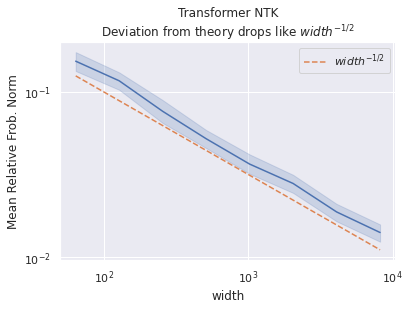

In [10]:
sns.lineplot(data=frob_df, x='width', y='relfrob')
widths = frob_df.width.unique()
plt.plot(widths, np.array(widths, dtype='float')**-0.5, '--', label=u'${width}^{-1/2}$')
plt.ylabel(u'Relative Frob. Norm')
plt.loglog()
plt.legend()
_ = plt.title(u'Transformer NTK\nDeviation from theory drops like $width^{-1/2}$')

In [11]:
frob_df.to_pickle('transformer_ntk.frob')